In [1]:
import glob
import os
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from multiprocessing import Process
import gc

import tensorflow as tf
import sklearn
import time

import numpy as np
import pandas as pd
from pandas import DataFrame

#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2024-02-23 17:13:52.492439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 17:13:52.689221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 17:13:53.380906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-23 17:13:53.381002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# argumentos
n = len(sys.argv)
print("Total arguments passed:", n)
iteracoes = 0
cycle_index = 0
finalIterations = 0
if(n > 0):
    for value in sys.argv:
        print("arg:", value)
        if("iterations=" in value):
            try:
                iteracoes = int(value.replace("iterations=",""))
            except:
                print("no")
        
        if("cycle=" in value):
            try:
                cycle_index = int(value.replace("cycle=",""))
            except:
                print("no")
print("iteracoes:",iteracoes)      
print("cycle:",cycle_index)

Total arguments passed: 3
arg: /home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/flower/lib/python3.9/site-packages/ipykernel_launcher.py
arg: -f
arg: /home/guilherme/.local/share/jupyter/runtime/kernel-2f21ffa6-5d59-4feb-b07c-35f8840e9b06.json
iteracoes: 0
cycle: 0


In [3]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolderPath = "../data_2019_processed/"

# General configuration
NUMBER_OF_ITERATIONS_FINAL = 200
    
NUM_EPOCHS = 1
BATCH_SIZE = 32
VERBOSE = 0


# usado para checkpoints
if(iteracoes > 0):
    NUMBER_OF_ITERATIONS_FINAL = iteracoes
    
NUMBER_OF_ITERATIONS = NUMBER_OF_ITERATIONS_FINAL


# output folder
outputFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
#outputFolder = "test_checkpoint"
checkPointFolder = outputFolder+"/checkpoints"
iferredCycleDataFolder = outputFolder+"/inferred_datasets"

# train file name modifier
fileSufixTrain = "_transformed" # _transformed_smote for smote
train_data_infered_sufix = ""
train_data_infered_sufix = "_filtered"

#fl.common.logger.configure(identifier="myFlowerExperiment", filename="log_"+outputFolder+".txt")

In [4]:
print("Checking whether checkpoint exist")
print(checkPointFolder)
print(checkPointFolder)
isExist = os.path.exists(checkPointFolder)
if not isExist:
    # Create a new directory because it does not exist
    print("There is no checkpoint available to continue the process!")
    sys.exit("There is no checkpoint available to continue the process!")

Checking whether checkpoint exist
result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints
result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints


In [5]:
print("Checking whether the data folder exists or not")
isExist = os.path.exists(iferredCycleDataFolder)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(iferredCycleDataFolder)
    print("The new directory is created! ",iferredCycleDataFolder)
else:
    print("The directory exists!")

Checking whether the data folder exists or not
The directory exists!


In [6]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]

In [7]:
# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']

In [8]:
def generateMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    #print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = ("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # generate metrics
    results, array= generateMetrics(y_test,yhat_probs)

    # accuracy: (tp + tn) / (p + n)
    accuracy = results['accuracy']
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = results['precision']
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = results['recall'] 
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = results['f1_score']
    print('F1 score: %f' % f1)
    # kappa
    kappa = results['cohen_kappa_score']
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = results['roc_auc_score']
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = results['matrix']
    print(matrix)
    
    return results, array

def generateGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def showGlobalMetrics(metrics):
    res = generateGlobalMetrics(metrics)
    
    accuracy = res[0]
    precision = res[1]
    recall = res[2]
    f1_score = res[3]
    cohen_kappa_score = res[4]
    roc_auc_score = res[5]
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return res

In [9]:
# take the list of directories and concat them
def loadDataFromFolders(foldersToLoad,inputFolders,fileType = "_transformed"):
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+fileType+".csv")
        #print(trainingDataSet[i])
        if(i == 0):
            temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+fileType+".csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+currentFolder+fileType+".csv")
            temp_data = pd.concat([temp_data, dataset])
    # return the dataset        
    return temp_data

# take the list of directories and concat them
def loadDataFromFoldersOnList(foldersToLoad,inputFolders,fileType = "_transformed"):
    clientList = []
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+fileType+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+fileType+".csv")
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

Load datasets

In [10]:
print("Preparing test data")
 
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadDataFromFolders(testFolders,inputFolderPath,fileSufixTrain)

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
8 datasets
0 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw ../data_2019_processed/student_rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw_transformed.csv
1 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI ../data_2019_processed/student_RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI_transformed.csv
2 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is ../data_2019_processed/student_VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is_transformed.csv
3 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw ../data_2019_processed/student_Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw_transformed.csv
4 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA ../data_2019_processed/student_XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA_transformed.csv
5 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw ../data_2019_processed/student_YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw_transformed.csv
6 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM ../data_2019_processed/student_ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM_transformed.csv


activity  location     timestamp  time_to_next_alarm     sound  \
0          0.75       1.0  0.000000e+00            0.000000  0.515992   
1          0.25       1.0  3.211282e-07            0.000000  0.542171   
2          0.25       1.0  6.422564e-07            0.000000  0.515992   
3          0.00       1.0  6.422564e-07            0.000000  0.515992   
4          0.25       1.0  6.422564e-07            0.000000  0.531341   
...         ...       ...           ...                 ...       ...   
13208      1.00       0.0  3.981050e-03            0.923909  0.577338   
13209      1.00       0.0  3.981050e-03            0.923809  0.612109   
13210      0.00       0.0  3.981371e-03            0.923611  0.573415   
13211      0.75       0.0  3.981693e-03            0.923611  0.538685   
13212      0.75       0.0  3.981693e-03            0.923512  0.542238   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000000          1.0     0.678249   
1            0.0         1.0  0.000007          1.0     0.678944   
2            0.0         1.0  0.000000          1.0     0.679639   
3            0.0         1.0  0.000000          1.0     0.680334   
4            0.0         1.0  0.000000          1.0     0.681028   
...          ...         ...       ...          ...          ...   
13208        1.0         0.0  0.000266          1.0     0.035441   
13209        1.0         0.0  0.000236          1.0     0.036136   
13210        1.0         0.0  0.000118          1.0     0.037526   
13211        1.0         0.0  0.000089          1.0     0.037526   
13212        1.0         0.0  0.000030          1.0     0.038221   

                  timestamp_text  class  
0      2018-05-14 16:16:08+00:00  awake  
1      2018-05-14 16:17:39+00:00  awake  
2      2018-05-14 16:18:39+00:00  awake  
3      2018-05-14 16:19:09+00:00  awake  
4      2018-05-14 16:20:09+00:00  awake  
...                          ...    ...  
13208  2018-06-05 00:51:21+00:00  awake  
13209  2018-06-05 00:52:21+00:00  awake  
13210  2018-06-05 00:54:11+00:00  awake  
13211  2018-06-05 00:54:41+00:00  awake  
13212  2018-06-05 00:55:42+00:00  awake  

[110603 rows x 12 columns]

In [11]:
print("Preparing X_train data")
# load cliend data
#clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,fileSufixTrain)
clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,"")
        
NUMBER_OF_CLIENTS = len(clientList)
print("Total",(len(clientList)))

Preparing X_train data
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_filtered.csv


FileNotFoundError: [Errno 2] No such file or directory: '../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_filtered.csv'

In [12]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

# transform output to one_hot_encoding for the input dataset
for i in range(0,len(clientList)):
    clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
    #print (clientList[i])
    

X_test.info()

NameError: name 'clientList' is not defined

In [72]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110603 entries, 0 to 13212
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            110603 non-null  float32
 1   location            110603 non-null  float32
 2   timestamp           110603 non-null  float64
 3   time_to_next_alarm  110603 non-null  float32
 4   sound               110603 non-null  float32
 5   proximity           110603 non-null  float32
 6   phone_lock          110603 non-null  float32
 7   light               110603 non-null  float32
 8   day_of_week         110603 non-null  float32
 9   minutes_day         110603 non-null  float32
 10  timestamp_text      110603 non-null  object 
 11  class               110603 non-null  object 
 12  awake               110603 non-null  float32
 13  asleep              110603 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 8.0+ MB


In [73]:
print("Prepering the test dataset")
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
#client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

#print(client_test_dataset.element_spec)
#client_test_dataset

Prepering the test dataset


--
--
Load model from checkpoint
--
--

In [74]:
print("creating model")

def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

creating model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [75]:
# comment for the future: I should load the models thinking on:
# 1 - best global accuracy
# 2 - best model for each device (I should save the best model for each device)
# 3 - maybe I have to try use the metric roc

print("Loading checkpoint model",checkPointFolder+"/round-*")
list_of_files = [fname for fname in glob.glob(checkPointFolder+"/round-*")]
last_round_checkpoint = -1
latest_round_file = None
model_check_point = None
filename_h5 = None
filename_np = None

if len(list_of_files) > 0:
    valuesTempString = [value.replace(outputFolder+"/checkpoints/round-","").replace("-weights.h5","").replace("-weights.npz","") for value in list_of_files]
    if(len(valuesTempString) > 0):
        last_round_checkpoint = max([int(value) for value in valuesTempString])
        print("Loading pre-trained model from: ", last_round_checkpoint)
        # load the name
        print("Last round: ",last_round_checkpoint)
    
        filename_h5 = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.h5"
        filename_np = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.npz"
else:
    print("No checkpoint file found")
    sys.exit("No checkpoint file found")

Loading checkpoint model result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-*
Loading pre-trained model from:  200
Last round:  200


In [76]:
# load model
# load checkpoint
print("load checkpoint")
keras_model.load_weights(filename_h5)

load checkpoint


In [77]:
def convert_to_decibels(value):
    if(value > 0.0):
        return 20 * (np.log(32768) - np.log(value/32768) )
        #return 20 * ( math.log(32768/value) )
        #return 20 * (np.log(value)) 
    else:
        return 0.0

def treat_data_to_0_1(value):
    if(value > 0.0):
        return 1.0
        #return 20 * ( math.log(32768/value) )
        #return 20 * (np.log(value)) 
    else:
        return 0.0
    
def transform_data(dataframe):
    # convert data and show the new info
    # activity
    dataframe['activity'] = dataframe['activity'].replace(['Unknown'], '1')
    dataframe['activity'] = dataframe['activity'].replace(['Still'], '2')
    dataframe['activity'] = dataframe['activity'].replace(['Tilting'], '3')
    dataframe['activity'] = dataframe['activity'].replace(['Exercise'], '4')
    dataframe['activity'] = dataframe['activity'].replace(['In vehicle'], '5')
    # class
    dataframe['class'] = dataframe['class'].replace(['awake'], '0')
    dataframe['class'] = dataframe['class'].replace(['asleep'], '1')
    # day_of_week
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Tuesday'], '1')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Wednesday'], '2')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Thursday'], '3')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Friday'], '4')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Saturday'], '5')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Sunday'], '6')
    dataframe['day_of_week'] = dataframe['day_of_week'].replace(['Monday'], '7')
    # phone_lock
    dataframe['phone_lock'] = dataframe['phone_lock'].replace(['not locked'], '0')
    dataframe['phone_lock'] = dataframe['phone_lock'].replace(['locked'], '1')
    # location
    dataframe['location'] = dataframe['location'].replace(['Other'], '1')
    dataframe['location'] = dataframe['location'].replace(['University'], '2')
    dataframe['location'] = dataframe['location'].replace(['House'], '3')
    
    # timestamp
    if 'timestamp2' in dataframe.columns:
        dataframe['timestamp_text'] = dataframe['timestamp']
        dataframe['timestamp'] = dataframe['timestamp2']
        del dataframe['timestamp2']
    if 'outside_range' in dataframe.columns:
        del dataframe['outside_range']
    if 'time_sleeping' in dataframe.columns:
        del dataframe['time_sleeping']
    if 'wakeup_time' in dataframe.columns:
        del dataframe['wakeup_time']
    if 'sleep_time' in dataframe.columns:
        del dataframe['sleep_time']
    if 'distanceHome' in dataframe.columns:
        del dataframe['distanceHome']    
    if 'showActuation' in dataframe.columns:
        del dataframe['showActuation'] 
    #dataframe['timestamp'] = dataframe['timestamp'].astype('datetime64[ns]')
    #dataframe['timestamp'] = dataframe['timestamp'].astype('int64')
    #dataframe['timestamp'] = datetime.strptime(dataframe['timestamp'],'%Y-%m-%d %H:%M:%S').timestamp() * 1000
    #dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'],'%Y-%m-%d %H:%M:%S') * 1000
    #dataframe['timestamp'] = dataframe['timestamp'].dt.second()
    # data_type
    #dataframe['activity'] = dataframe['activity'].astype(np.integer) 
    #dataframe['class'] = dataframe['class'].astype(np.integer) 
    #dataframe['day_of_week'] = dataframe['day_of_week'].astype(np.integer) 
    #dataframe['phone_lock'] = dataframe['phone_lock'].astype(np.integer) 
    #dataframe['location'] = dataframe['location'].astype(np.integer) 
    dataframe['sound'] = dataframe['sound'].apply(convert_to_decibels)
    dataframe['proximity'] = dataframe['proximity'].apply(treat_data_to_0_1)
    dataframe['activity'] = dataframe['activity'].astype('int32')
    dataframe['class'] = dataframe['class'].astype('int32')
    dataframe['day_of_week'] = dataframe['day_of_week'].astype('int32')
    dataframe['phone_lock'] = dataframe['phone_lock'].astype('int32') 
    dataframe['location'] = dataframe['location'].astype('int32')
    #dataframe['minutes_day'] = dataframe['minutes_day'].astype('float32')
    dataframe['time_to_next_alarm'] = dataframe['time_to_next_alarm'].astype('float32')
    dataframe['sound'] = dataframe['sound'].astype('float32')
    dataframe['light'] = dataframe['light'].astype('float32')
    dataframe['proximity'] = dataframe['proximity'].astype('float32')
    dataframe['timestamp'] = dataframe['timestamp'].astype('float32')
    
    temp = dataframe['class'].copy()
    del dataframe['class']
    dataframe['class'] = temp
    #return dataframe
    return dataframe

def transform_normalize_data(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != "class" and feature_name != "timestamp_text":
            max_value = df[feature_name].max()
            if(feature_name == "timestamp"):
                max_value = 1924905600.0 #2030-12-31 00:00:00  
            if(feature_name == "day_of_week"):
                max_value = 7            
            if(feature_name == "sound"):
                max_value = 403 # overhal higher value            
            if(feature_name == "location"):
                max_value = 3
            if(feature_name == "activity"):
                max_value = 5
            if(feature_name == "minutes_day"):
                max_value = 1439 # 24 horas
            if(feature_name == "time_to_next_alarm"):
                max_value = 604800000.0 # 2.8 years in ms
            min_value = df[feature_name].min()
            print(feature_name+" "+str(min_value)+" "+str(max_value))
            if feature_name not in ["showActuation", "awake", "asleep"] and  (df[feature_name].dtype != object):
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            if(max_value == 0 and min_value == 0):
                result[feature_name] = 0.0
    return result

def transform_data_type2(dataset):
    # diminui o tamanho do tipo de dado (float32 é mais que o suficiente)
    dataset['activity'] = dataset['activity'].astype('int32')
    dataset['location'] = dataset['location'].astype('int32')
    dataset['timestamp'] = dataset['timestamp'].astype('float32')
    dataset['day_of_week'] = dataset['day_of_week'].astype('int32')
    dataset['light'] = dataset['light'].astype('int32')
    dataset['phone_lock'] = dataset['phone_lock'].astype('int32')
    dataset['proximity'] = dataset['proximity'].astype('int32')
    dataset['sound'] = dataset['sound'].astype('float32')
    dataset['time_to_next_alarm'] = dataset['time_to_next_alarm'].astype('float32')
    
    return dataset

def transform_output_to_str(dataframe):
    dataframe['class'] = dataframe['class'].apply(str)
    #print(dataframe['class'])
    dataframe['class'] = dataframe['class'].replace(to_replace='0',value='awake')
    dataframe['class'] = dataframe['class'].replace(to_replace='1',value='asleep')
    
    return dataframe

def transform_output_to_numeric(dataframe):
    dataframe['class'] = dataframe['class'].replace(['awake'], '0')
    dataframe['class'] = dataframe['class'].replace(['asleep'], '1')
    
    dataframe['class'] = dataframe['class'].astype('int32')
    
    if("awake" in dataframe.columns):
        dataframe['awake'] = dataframe['awake'].astype('int32')
        dataframe['asleep'] = dataframe['asleep'].astype('int32')
    
    return dataframe

In [78]:
clientList[0]

activity    location  distanceHome  showActuation   timestamp  \
0       Unknown       Other             0          False  1526390445   
1       Unknown       Other             0          False  1526390445   
2         Still  University             0          False  1526390475   
3         Still  University             0          False  1526390505   
4         Still  University             0          False  1526390535   
...         ...         ...           ...            ...         ...   
17988     Still       House             0          False  1528892024   
17989   Unknown       House             0          False  1528892094   
17990  Exercise       House             0          False  1528892144   
17991   Unknown       House             0          False  1528892175   
17992     Still       House             0          False  1528892241   

       time_to_next_alarm  sound  proximity  phone_lock  light day_of_week  \
0             594000000.0      0          5  not locked     37     Tuesday   
1             594000000.0      0          5  not locked     37     Tuesday   
2             593940000.0   5517          5  not locked     35     Tuesday   
3             593940000.0   5517          5  not locked    307     Tuesday   
4             593880000.0   5809          5  not locked     42     Tuesday   
...                   ...    ...        ...         ...    ...         ...   
17988         594720000.0   7974          0      locked      0   Wednesday   
17989         594660000.0  10516          0      locked      0   Wednesday   
17990         594600000.0  10516          0      locked      0   Wednesday   
17991         594600000.0   4438          0      locked      0   Wednesday   
17992         594540000.0   4438          0      locked      0   Wednesday   

       minutes_day  sleep_time  wakeup_time  time_sleeping  \
0              860        1020          660          64808   
1              860        1020          660          64808   
2              861        1020          660          64808   
3              861        1020          660          64808   
4              862        1020          660          64808   
...            ...         ...          ...            ...   
17988          793           0            0              0   
17989          794           0            0              0   
17990          795           0            0              0   
17991          796           0            0              0   
17992          797           0            0              0   

                  timestamp_text  class  awake  asleep  
0      2018-05-15 14:20:45+00:00  awake   True   False  
1      2018-05-15 14:20:45+00:00  awake   True   False  
2      2018-05-15 14:21:15+00:00  awake   True   False  
3      2018-05-15 14:21:45+00:00  awake   True   False  
4      2018-05-15 14:22:15+00:00  awake   True   False  
...                          ...    ...    ...     ...  
17988  2018-06-13 13:13:44+00:00  awake   True   False  
17989  2018-06-13 13:14:54+00:00  awake   True   False  
17990  2018-06-13 13:15:44+00:00  awake   True   False  
17991  2018-06-13 13:16:15+00:00  awake   True   False  
17992  2018-06-13 13:17:21+00:00  awake   True   False  

[17993 rows x 19 columns]

In [79]:
print("Transform data")
for i in range(0,len(trainFolders)): 
    # selects the data to train and test
    print()
    print()
    clientList[i] = transform_data(clientList[i])
    clientList[i] = transform_normalize_data(clientList[i])
    clientList[i] = transform_output_to_numeric(clientList[i])
    clientList[i] = transform_data_type(clientList[i])


Transform data


activity 1 5
location 1 3
timestamp 1526390400.0 1924905600.0
time_to_next_alarm 0.0 604800000.0
sound 0.0 403
proximity 0.0 1.0
phone_lock 0 1
light 0.0 60000.0
day_of_week 1 7
minutes_day 0 1439
awake False True
asleep False True


activity 1 5
location 1 3
timestamp 1526415200.0 1924905600.0
time_to_next_alarm -1.0 604800000.0
sound 0.0 403
proximity 0.0 0.0
phone_lock 0 1
light 0.0 0.0
day_of_week 1 7
minutes_day 0 1439
awake False True
asleep False True


activity 1 5
location 1 3
timestamp 1526390500.0 1924905600.0
time_to_next_alarm -1.0 604800000.0
sound 0.0 403
proximity 0.0 0.0
phone_lock 0 1
light 0.0 0.0
day_of_week 1 7
minutes_day 0 1439
awake False True
asleep False True


activity 1 5
location 1 3
timestamp 1526142200.0 1924905600.0
time_to_next_alarm -1.0 604800000.0
sound 0.0 403
proximity 0.0 1.0
phone_lock 0 1
light 0.0 0.0
day_of_week 1 7
minutes_day 0 1439
awake False True
asleep False True


activity 1 5
location 1 3
timestamp 1526215300.0 1924905

In [80]:
clientList[0]

activity  location     timestamp  time_to_next_alarm     sound  \
0          0.00       0.0  0.000000e+00            0.982143  0.000000   
1          0.00       0.0  0.000000e+00            0.982143  0.000000   
2          0.25       0.5  3.211923e-07            0.982044  0.604408   
3          0.25       0.5  3.211923e-07            0.982044  0.604408   
4          0.25       0.5  3.211923e-07            0.981944  0.601849   
...         ...       ...           ...                 ...       ...   
17988      0.25       1.0  6.277381e-03            0.983333  0.586128   
17989      0.00       1.0  6.277381e-03            0.983234  0.572395   
17990      0.75       1.0  6.277703e-03            0.983135  0.572395   
17991      0.00       1.0  6.277703e-03            0.983135  0.615209   
17992      0.25       1.0  6.278024e-03            0.983036  0.615209   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000617     0.000000     0.597637   
1            1.0         0.0  0.000617     0.000000     0.597637   
2            1.0         0.0  0.000583     0.000000     0.598332   
3            1.0         0.0  0.005117     0.000000     0.598332   
4            1.0         0.0  0.000700     0.000000     0.599027   
...          ...         ...       ...          ...          ...   
17988        0.0         1.0  0.000000     0.166667     0.551077   
17989        0.0         1.0  0.000000     0.166667     0.551772   
17990        0.0         1.0  0.000000     0.166667     0.552467   
17991        0.0         1.0  0.000000     0.166667     0.553162   
17992        0.0         1.0  0.000000     0.166667     0.553857   

                  timestamp_text  awake  asleep  class  
0      2018-05-15 14:20:45+00:00    1.0     0.0      0  
1      2018-05-15 14:20:45+00:00    1.0     0.0      0  
2      2018-05-15 14:21:15+00:00    1.0     0.0      0  
3      2018-05-15 14:21:45+00:00    1.0     0.0      0  
4      2018-05-15 14:22:15+00:00    1.0     0.0      0  
...                          ...    ...     ...    ...  
17988  2018-06-13 13:13:44+00:00    1.0     0.0      0  
17989  2018-06-13 13:14:54+00:00    1.0     0.0      0  
17990  2018-06-13 13:15:44+00:00    1.0     0.0      0  
17991  2018-06-13 13:16:15+00:00    1.0     0.0      0  
17992  2018-06-13 13:17:21+00:00    1.0     0.0      0  

[17993 rows x 14 columns]

In [81]:
# for each data infer the output and save the new value
print(len(trainFolders), "datasets")
for i in range(0,len(trainFolders)): 
    currentFolder = trainFolders[i]
    # selects the data to train and test
    X_train_data = clientList[i][inputFeatures]
    y_train_label = clientList[i][outputClasses]

    inputData = X_train_data
    outputFileName = iferredCycleDataFolder+"/student_"+currentFolder+".csv"
    print(i , "-", outputFileName)
    #print(trainingDataSet[i])
    
    yhat_probs = keras_model.predict(inputData,verbose=VERBOSE)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 

    outputData = pd.concat([inputData,y_predicted_df], axis=1)
    #inputData['awake'] = y_predicted_df['awake']
    #inputData['asleep'] = y_predicted_df['asleep']

    outputData.to_csv(outputFileName, sep=',', encoding='utf-8', index=False)

19 datasets
0 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
1 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
2 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
3 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
4 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA.csv
5 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4.csv
6 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc.csv
7 - result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U.csv
8 - result_u

In [56]:

outputData

activity  location  day_of_week  light  phone_lock  proximity  \
0             0         0            0      0           0          0   
1             0         0            0      0           0          0   
2             0         0            0      0           0          1   
3             0         0            0      0           0          1   
4             0         0            0      0           0          1   
...         ...       ...          ...    ...         ...        ...   
12704         0         1            0      0           1          1   
12705         0         1            0      0           1          1   
12706         0         1            0      0           1          1   
12707         0         1            0      0           0          0   
12708         0         0            0      0           1          0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  
0      0.000000            0.000000     0.724114    1.0     0.0  
1      0.000000            0.000000     0.724809    1.0     0.0  
2      0.000000            0.902282     0.100764    1.0     0.0  
3      0.000000            0.901786     0.104239    1.0     0.0  
4      0.000000            0.000000     0.109798    1.0     0.0  
...         ...                 ...          ...    ...     ...  
12704  0.644370            0.992956     0.549687    1.0     0.0  
12705  0.644370            0.992956     0.550382    1.0     0.0  
12706  0.624127            0.992857     0.551077    1.0     0.0  
12707  0.540295            0.992758     0.551772    1.0     0.0  
12708  0.581746            0.991171     0.562196    1.0     0.0  

[12709 rows x 11 columns]

In [83]:
# compare data
# for each data infer the output and save the new value
datasetsMixed = []
print(len(trainFolders), "datasets")
for i in range(0,len(trainFolders)): 
    currentFolder = trainFolders[i]
    # selects the data to train and test
    X_train_data = clientList[i][inputFeatures]
    y_train_label = clientList[i][outputClasses]

    inputData = X_train_data
    outputFileName = iferredCycleDataFolder+"/student_"+currentFolder+".csv"
    print("Reading",i , outputFileName)
    #print(trainingDataSet[i])
    
    yhat_probs = keras_model.predict(inputData,verbose=VERBOSE)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake_pred','asleep_pred']) 

    outputData = pd.concat([inputData,y_train_label,y_predicted_df], axis=1)
    #inputData['awake'] = y_predicted_df['awake']
    #inputData['asleep'] = y_predicted_df['asleep']

    datasetsMixed.append(outputData)

19 datasets
Reading 0 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
Reading 1 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
Reading 2 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
Reading 3 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
Reading 4 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA.csv
Reading 5 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4.csv
Reading 6 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc.csv
Reading 7 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_Ch3u5Oaz96VS

In [84]:
datasetsMixed[0]

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.000000  0.000617         0.0        1.0   
1          0.00       0.0     0.000000  0.000617         0.0        1.0   
2          0.25       0.5     0.000000  0.000583         0.0        1.0   
3          0.25       0.5     0.000000  0.005117         0.0        1.0   
4          0.25       0.5     0.000000  0.000700         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
17988      0.25       1.0     0.166667  0.000000         1.0        0.0   
17989      0.00       1.0     0.166667  0.000000         1.0        0.0   
17990      0.75       1.0     0.166667  0.000000         1.0        0.0   
17991      0.00       1.0     0.166667  0.000000         1.0        0.0   
17992      0.25       1.0     0.166667  0.000000         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  awake_pred  \
0      0.000000            0.982143     0.597637    1.0     0.0         1.0   
1      0.000000            0.982143     0.597637    1.0     0.0         1.0   
2      0.604408            0.982044     0.598332    1.0     0.0         1.0   
3      0.604408            0.982044     0.598332    1.0     0.0         1.0   
4      0.601849            0.981944     0.599027    1.0     0.0         1.0   
...         ...                 ...          ...    ...     ...         ...   
17988  0.586128            0.983333     0.551077    1.0     0.0         1.0   
17989  0.572395            0.983234     0.551772    1.0     0.0         1.0   
17990  0.572395            0.983135     0.552467    1.0     0.0         1.0   
17991  0.615209            0.983135     0.553162    1.0     0.0         1.0   
17992  0.615209            0.983036     0.553857    1.0     0.0         1.0   

       asleep_pred  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
17988          0.0  
17989          0.0  
17990          0.0  
17991          0.0  
17992          0.0  

[17993 rows x 13 columns]

In [85]:
metrics = None
metricsa = None
metricsAll = []
predOutputClasses = ["awake_pred","asleep_pred"]
for i in range(0,len(datasetsMixed)): 
    currentOne = datasetsMixed[i]
    currentOne = transform_data_type(currentOne)
    realLabel = currentOne[outputClasses]     # ['awake', 'asleep']
    predLabel = currentOne[predOutputClasses]
    
    
    metrics,metricsa = generateMetrics(realLabel["awake"],predLabel["awake_pred"])
    metricsAll.append(metrics)
    print()
    print()
    printMetrics(realLabel["awake"],predLabel["awake_pred"])
    #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
    print()
    print()



Accuracy: 0.899961
Precision: 0.930589
Recall: 0.961569
F1 score: 0.945826
Cohens kappa: 0.295924
ROC AUC: 0.626063
\Confusion Matrix
[[ 480 1172][ 628 15713]]




Accuracy: 0.686186
Precision: 0.739886
Recall: 0.856337
F1 score: 0.793864
Cohens kappa: 0.151253
ROC AUC: 0.567311
\Confusion Matrix
[[ 947 2456][ 1172 6986]]




Accuracy: 0.804611
Precision: 0.843368
Recall: 0.834787
F1 score: 0.839055
Cohens kappa: 0.590482
ROC AUC: 0.796089
\Confusion Matrix
[[ 999 320][ 341 1723]]




Accuracy: 0.876683
Precision: 0.936796
Recall: 0.917762
F1 score: 0.927181
Cohens kappa: 0.525136
ROC AUC: 0.775684
\Confusion Matrix
[[ 1776 1027][ 1364 15222]]




Accuracy: 0.909916
Precision: 0.963404
Recall: 0.933223
F1 score: 0.948074
Cohens kappa: 0.608995
ROC AUC: 0.835113
\Confusion Matrix
[[ 241 86][ 162 2264]]




Accuracy: 0.733918
Precision: 0.882745
Recall: 0.786655
F1 score: 0.831935
Cohens kappa: 0.203558
ROC AUC: 0.624719
\Confusion Matrix
[[ 2002 2324][ 4745 17496]]




Accuracy: 0.865

In [86]:
metrics

{'accuracy': 0.8538830749862303,
 'precision': 0.9632523955716811,
 'recall': 0.8762694651320244,
 'f1_score': 0.9177044094837137,
 'cohen_kappa_score': 0.27955135653445373,
 'roc_auc_score': 0.7169701189041982,
 'matrix': '[[ 498 395][ 1462 10354]]',
 'TP': 498,
 'FP': 395,
 'FN': 1462,
 'TN': 10354}

In [87]:
metricsAll

[{'accuracy': 0.8999610959817707,
  'precision': 0.930589280426414,
  'recall': 0.9615690594210881,
  'f1_score': 0.9458255582977186,
  'cohen_kappa_score': 0.29592376044373014,
  'roc_auc_score': 0.6260629800737401,
  'matrix': '[[ 480 1172][ 628 15713]]',
  'TP': 480,
  'FP': 1172,
  'FN': 628,
  'TN': 15713},
 {'accuracy': 0.6861863160626244,
  'precision': 0.7398856174539292,
  'recall': 0.8563373375827409,
  'f1_score': 0.7938636363636363,
  'cohen_kappa_score': 0.15125320511212037,
  'roc_auc_score': 0.567310602379381,
  'matrix': '[[ 947 2456][ 1172 6986]]',
  'TP': 947,
  'FP': 2456,
  'FN': 1172,
  'TN': 6986},
 {'accuracy': 0.804611291752882,
  'precision': 0.8433675966715615,
  'recall': 0.8347868217054264,
  'f1_score': 0.8390552714877039,
  'cohen_kappa_score': 0.5904821135589436,
  'roc_auc_score': 0.7960893926571105,
  'matrix': '[[ 999 320][ 341 1723]]',
  'TP': 999,
  'FP': 320,
  'FN': 341,
  'TN': 1723},
 {'accuracy': 0.8766826551137242,
  'precision': 0.936796110529

In [88]:
currentOne

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.333333  0.000000         0.0        0.0   
1          0.00       0.0     0.333333  0.000000         0.0        0.0   
2          0.00       0.0     0.500000  0.000470         0.0        1.0   
3          0.00       0.0     0.500000  0.000529         0.0        1.0   
4          0.00       0.0     0.500000  0.000941         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
12704      0.25       1.0     0.000000  0.000000         1.0        1.0   
12705      0.25       1.0     0.000000  0.000000         1.0        1.0   
12706      0.25       1.0     0.000000  0.002234         1.0        1.0   
12707      0.00       1.0     0.000000  0.000000         0.0        0.0   
12708      0.25       0.0     0.000000  0.000020         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  awake_pred  \
0      0.000000            0.000000     0.724114    1.0     0.0         1.0   
1      0.000000            0.000000     0.724809    1.0     0.0         1.0   
2      0.000000            0.902282     0.100764    1.0     0.0         1.0   
3      0.000000            0.901786     0.104239    1.0     0.0         1.0   
4      0.000000            0.000000     0.109798    1.0     0.0         1.0   
...         ...                 ...          ...    ...     ...         ...   
12704  0.644370            0.992956     0.549687    1.0     0.0         1.0   
12705  0.644370            0.992956     0.550382    1.0     0.0         1.0   
12706  0.624127            0.992857     0.551077    1.0     0.0         1.0   
12707  0.540295            0.992758     0.551772    1.0     0.0         1.0   
12708  0.581746            0.991171     0.562196    1.0     0.0         1.0   

       asleep_pred  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
12704          0.0  
12705          0.0  
12706          0.0  
12707          0.0  
12708          0.0  

[12709 rows x 13 columns]

In [89]:
datasetsMixed[i][predOutputClasses]

awake_pred  asleep_pred
0             1.0          0.0
1             1.0          0.0
2             1.0          0.0
3             1.0          0.0
4             1.0          0.0
...           ...          ...
12704         1.0          0.0
12705         1.0          0.0
12706         1.0          0.0
12707         1.0          0.0
12708         1.0          0.0

[12709 rows x 2 columns]

In [90]:
realLabel

awake  asleep
0        1.0     0.0
1        1.0     0.0
2        1.0     0.0
3        1.0     0.0
4        1.0     0.0
...      ...     ...
12704    1.0     0.0
12705    1.0     0.0
12706    1.0     0.0
12707    1.0     0.0
12708    1.0     0.0

[12709 rows x 2 columns]

In [91]:
predLabel

awake_pred  asleep_pred
0             1.0          0.0
1             1.0          0.0
2             1.0          0.0
3             1.0          0.0
4             1.0          0.0
...           ...          ...
12704         1.0          0.0
12705         1.0          0.0
12706         1.0          0.0
12707         1.0          0.0
12708         1.0          0.0

[12709 rows x 2 columns]

In [92]:
#np.array(attribute1).T

In [93]:
#attribute1

In [94]:
#np.array(attribute1)

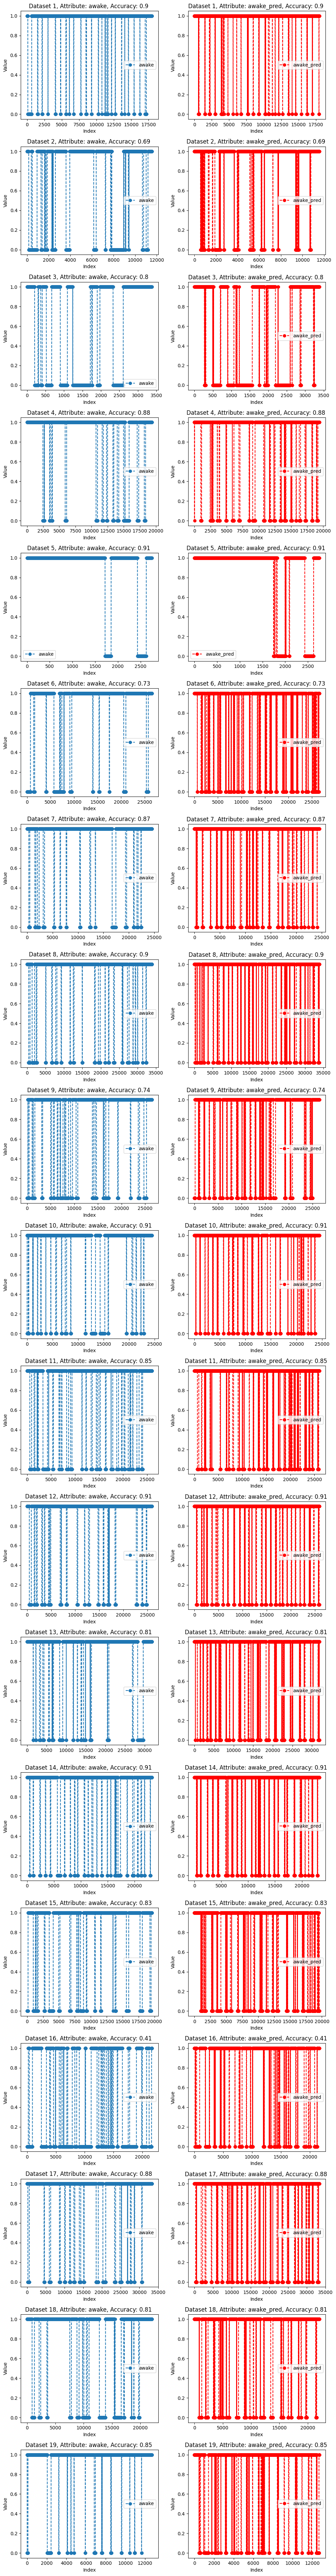

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed  # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

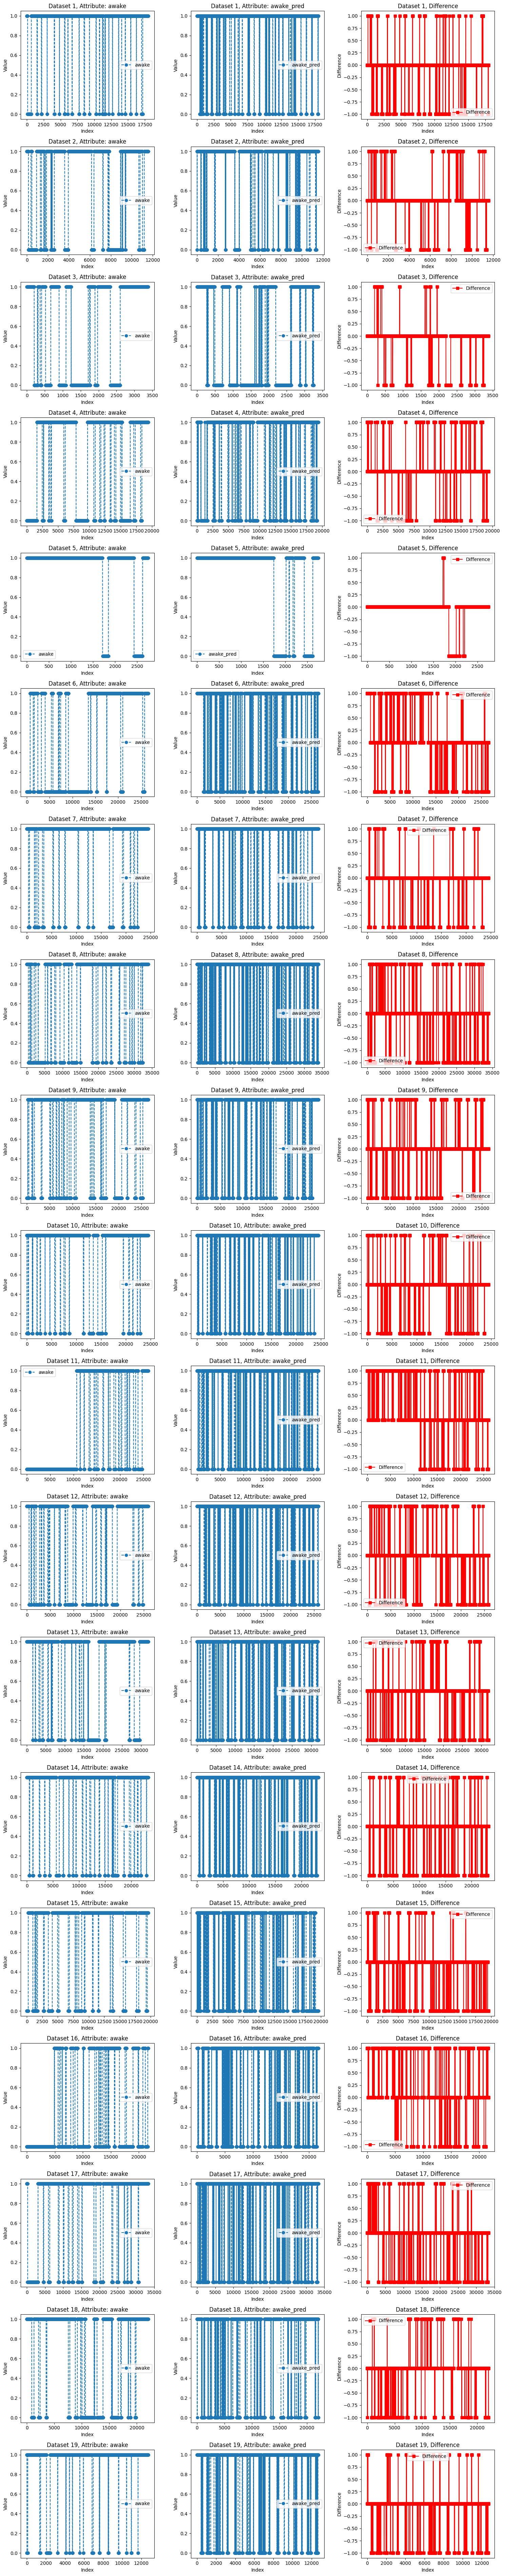

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed  # Your array with 18 datasets
selectedAttributes = ['awake', 'awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes + 1  # Three subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

    # Calculate and plot the difference between the selected attributes
    diff = dataset[selectedAttributes[1]] - dataset[selectedAttributes[0]]
    ax_diff = axs[i, num_attributes]  # Access the third subplot in the row
    ax_diff.plot(diff, label='Difference', linestyle='-', marker='s', color='red')
    ax_diff.set_title(f'Dataset {i+1}, Difference')
    ax_diff.set_xlabel('Index')
    ax_diff.set_ylabel('Difference')
    ax_diff.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
